## **Word2Vec (CBOW, Skip-gram)**
1. 라이브러리를 활용하지 않고 CBOW, Skip-gram 모델을 각각 구현, 학습합니다.
3. gensim 라이브러리를 활용하여 CBOW, Skip-gram 모델을 학습하고 시각화합니다.

## **1. Word2Vec 구현 및 학습**

### 1.1 필요한 패키지 import

In [ ]:
!pip install konlpy

In [ ]:
from tqdm import tqdm
from konlpy.tag import Okt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### 1.2 Dataset 구축

Sample 데이터를 확인합니다.
데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [ ]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

KoNLPy 패키지에서 제공하는 Twitter(Okt) tokenizer를 사용하여 tokenization합니다.

In [ ]:
tokenizer = Okt()

In [ ]:
def make_tokenized(data):
    tokenized = []
    for sent in tqdm(data):
        tokens = tokenizer.morphs(sent, stem=True)
        tokenized.append(tokens)

    return tokenized

In [ ]:
train_tokenized = make_tokenized(train_data) 

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [ ]:
train_tokenized

[['정말', '맛있다', '.', '추천', '하다', '.'],
 ['기대하다', '것', '보단', '별로', '이다', '.'],
 ['다',
  '좋다',
  '가격',
  '이',
  '너무',
  '비싸다',
  '다시',
  '가다',
  '싶다',
  '생각',
  '이',
  '안',
  '드네',
  '요',
  '.'],
 ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'],
 ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'],
 ['위생',
  '상태',
  '가',
  '좀',
  '별로',
  '이다',
  '.',
  '좀',
  '더',
  '개선',
  '되다',
  '기르다',
  '바라다',
  '.'],
 ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'],
 ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'],
 ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'],
 ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

Tokenize 된 단어의 빈도 수를 확인할 수 있는 `word_count` 를 생성합니다.

In [ ]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
    for token in tokens:
        word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 12.76it/s]


가장 많이 등장한 토큰부터 적게 등장한 토큰 순으로 나열하여 `word_count` 를 확인해 봅니다.

In [ ]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


각 단어를 정수 값(index) 에 mapping 하는 word to index (`w2i`) 를 생성합니다.

`w2i` 의 전체 크기는 고유한 단어의 개수(vocab size)와 동일합니다.

In [ ]:
w2i = {} 
for pair in tqdm(word_count):
    if pair[0] not in w2i:
        w2i[pair[0]] = len(w2i)

100%|██████████| 60/60 [00:00<00:00, 310689.19it/s]


In [ ]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

**Tip** `torch.utils.data.Dataset`


---
파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 Dataset과 DataLoader를 제공합니다.

이 도구를 활용하면 미니 배치 학습, 데이터 셔플, 병렬 처리를 간단히 수행할 수 있습니다. 

Dataset 를 정의하고 이를 DataLoader 에 전달함으로써 사용할 수 있습니다.

파이토치에서 제공하는 Dataset 을 커스텀하여 `CBOWDataset` 과 `SkipGramDataset` 을 정의해 봅시다.

`__init__`, `__len__`, `__getitem__` 을 다시 정의함으로써 커스텀할 수 있습니다.

출처: https://wikidocs.net/55580


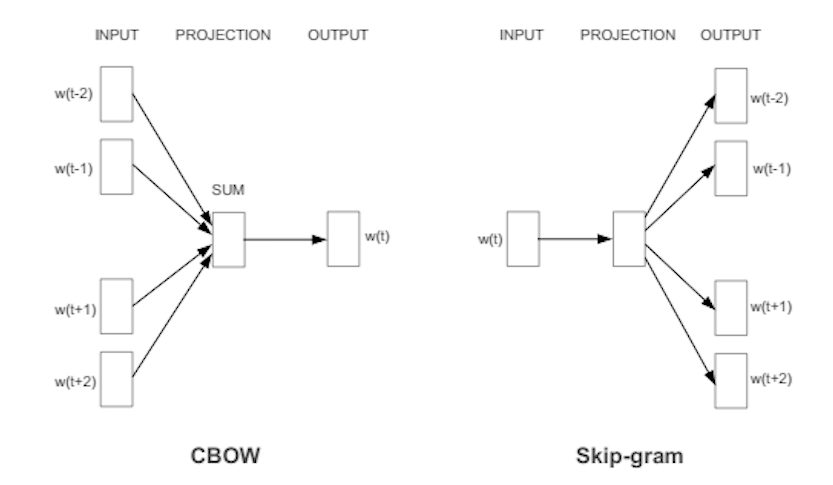

CBOW 는 window 내에 있는 context word를 가지고 target word 하나를 맞추는 과정에서 학습됩니다.

Skip-gram 은 target word 하나를 가지고 주변 context word 를 맞추는 과정에서 학습됩니다.

In [ ]:
class CBOWDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2):
        self.x = []
        self.y = []

        ## TO DO (START) ##
        for tokens in tqdm(train_tokenized):
            token_ids = [w2i[token] for token in tokens]
            for i, id in enumerate(token_ids):
                if i-window_size >= 0 and i+window_size < len(token_ids):
                    self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
                    self.y.append(id)
        ## TO DO (END) ##
        
        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2):
        self.x = []
        self.y = []

        ## TO DO (START) ##
        for tokens in tqdm(train_tokenized):
            token_ids = [w2i[token] for token in tokens]
            for i, id in enumerate(token_ids):
                if i-window_size >= 0 and i+window_size < len(token_ids):
                    self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
                    self.x += ([id] * 2 * window_size)
        ## TO DO (END) ##

        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [ ]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 35365.13it/s]

[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

In [ ]:
skipgram_set.__getitem__(0)

(tensor(0), tensor(17))

### 1.3 모델 Class 구현

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


**Tip** `nn.Embedding` 


---


위에서 단어(토큰)을 고유한 정수 값으로 매핑하기 위해 정의한 `w2i` 를 떠올려 봅시다. <br>
입력 시퀀스의 단어를 모델의 입력으로 사용하기 위해서는,

1. `w2i` 를 이용해 각 단어를 고유한 정수 값으로 인코딩합니다.
2. 인코딩된 정수 시퀀스를 임베딩 층에 통과시킵니다.
3. 입력 시퀀스의 길이와 동일한 개수의 임베딩 벡터를 얻습니다. <br>

`nn.Embedding` 은 전체 어휘 집합 개수의 임베딩 벡터들 가운데 각 단어의 인덱스에 해당한는 임베딩 벡터에 접근하는 lookup table 로써 2번을 할 수 있도록 해줍니다. 

임베딩 벡터는 훈련 과정에서 학습됩니다.



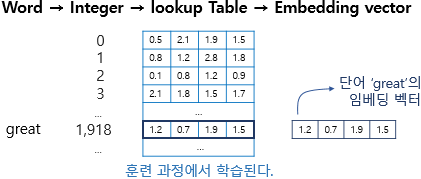

출처: https://wikidocs.net/64779

`nn.Embedding` 의 input 과 output 은 다음과 같습니다.


*   Input: (*), IntTensor or LongTensor of arbitrary shape containing the indices to extract
*   Output: (*, $H$), where * is the input shape and $H =\text{embediding_dim}$

```
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)
tensor([[[-0.0251, -1.6902,  0.7172],
         [-0.6431,  0.0748,  0.6969],
         [ 1.4970,  1.3448, -0.9685],
         [-0.3677, -2.7265, -0.1685]],

        [[ 1.4970,  1.3448, -0.9685],
         [ 0.4362, -0.4004,  0.9400],
         [-0.6431,  0.0748,  0.6969],
         [ 0.9124, -2.3616,  1.1151]]])
```



출처: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html



In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x):  # x: (B, 2W)
        
        ## TO DO (START) ##
        embeddings = self.embedding(x)  # (B, 2W, d_w)
        embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
        output = self.linear(embeddings)  # (B, V)
        ## TO DO (END) ##

        return output

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x): # x: (B)
        
        ## TO DO (START) ##
        embeddings = self.embedding(x)  # (B, d_w)
        output = self.linear(embeddings)  # (B, V)
        ## TO DO (END) ##

        return output

두 가지 모델을 생성합니다.

In [ ]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### 1.4 모델 학습 

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

**Tip** `torch.utils.data.DataLoader` 


---

Dataloader 는 앞서 정의한 Dataset 를 전달 받아 학습 과정에서 모델의 입력으로 사용할 수 있도록 데이터를 load 해줍니다. 

batch_size 를 정해줌으로써 미니 배치 학습이 가능한 형태로 데이터를 가공합니다.

예를 들어, 전체 데이터 수가 100 개 이고 batch size 가 20인 경우, 데이터는 20개의 데이터가 하나의 배치로 묶여 총 5개 의 배치로 구성됩니다.
즉, (100, ) 사이즈의 데이터가 (5, 20, ) 로 변하게 됩니다.

모델을 학습할 때에는 for loop 을 돌면서 한 iteration 에 하나의 배치를 데이터 로더로부터 전달 받아 모델의 입력으로 사용합니다.


```
# Example of DataLoader usage
for batch in data_loader:
    output = model(batch)
```


In [ ]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.


In [ ]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(cbow_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)

        output = cbow(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:00<00:00, 231.27it/s]


Train loss: 4.983058929443359
Train loss: 4.071436882019043
Train loss: 4.36237096786499
Train loss: 3.881404399871826
Train loss: 4.581122398376465
Train loss: 5.347768306732178
Train loss: 3.879242420196533
Train loss: 5.179789066314697
Train loss: 5.646038055419922
Train loss: 5.412302017211914
Train loss: 5.229724884033203
Train loss: 6.464803695678711
Train loss: 4.94390869140625
Train loss: 4.973870277404785
Train loss: 4.766401767730713
Train loss: 4.968501091003418
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 257.09it/s]


Train loss: 4.790680885314941
Train loss: 3.9446117877960205
Train loss: 4.243180274963379
Train loss: 3.7576866149902344
Train loss: 4.468057632446289
Train loss: 5.066380500793457
Train loss: 3.685136318206787
Train loss: 5.038365364074707
Train loss: 5.52031135559082
Train loss: 5.229306221008301
Train loss: 5.051392078399658
Train loss: 6.0422539710998535
Train loss: 4.7841339111328125
Train loss: 4.8452229499816895
Train loss: 4.591059684753418
Train loss: 4.811767578125
##################################################
Epoch: 3


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 4.607049465179443
Train loss: 3.8207345008850098
Train loss: 4.125423908233643
Train loss: 3.6362831592559814
Train loss: 4.357064247131348
Train loss: 4.791974067687988
Train loss: 3.501255512237549
Train loss: 4.901948928833008
Train loss: 5.397651195526123
Train loss: 5.050383567810059
Train loss: 4.876461029052734
Train loss: 5.631523132324219


100%|██████████| 16/16 [00:00<00:00, 225.44it/s]


Train loss: 4.627058029174805
Train loss: 4.720882415771484
Train loss: 4.421054363250732
Train loss: 4.661408424377441
##################################################
Epoch: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 4.431373596191406
Train loss: 3.6998062133789062
Train loss: 4.009159088134766
Train loss: 3.517178535461426
Train loss: 4.248048782348633
Train loss: 4.525468826293945
Train loss: 3.3273372650146484
Train loss: 4.769953727722168
Train loss: 5.277861595153809


100%|██████████| 16/16 [00:00<00:00, 214.21it/s]


Train loss: 4.875583171844482
Train loss: 4.705197334289551
Train loss: 5.232780456542969
Train loss: 4.472698211669922
Train loss: 4.600376129150391
Train loss: 4.256671905517578
Train loss: 4.516572952270508
##################################################
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 4.263081073760986
Train loss: 3.5818369388580322
Train loss: 3.8944408893585205
Train loss: 3.400379180908203
Train loss: 4.140926837921143
Train loss: 4.268045902252197
Train loss: 3.163111925125122
Train loss: 4.641781330108643
Train loss: 5.1607818603515625
Train loss: 4.705012321472168
Train loss: 4.53793478012085
Train loss: 4.846635818481445


100%|██████████| 16/16 [00:00<00:00, 198.11it/s]

Train loss: 4.321094036102295
Train loss: 4.483315467834473
Train loss: 4.098169326782227
Train loss: 4.376572132110596
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(skipgram_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)

        #import pdb; pdb.set_trace()
        output = skipgram(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.028356552124023
Train loss: 4.069888591766357
Train loss: 4.018750190734863
Train loss: 4.239040374755859
Train loss: 4.15057373046875
Train loss: 4.285935401916504
Train loss: 4.5694146156311035
Train loss: 4.260439872741699
Train loss: 4.430561542510986
Train loss: 4.278116703033447
Train loss: 4.020684242248535
Train loss: 4.207589626312256
Train loss: 4.474374294281006
Train loss: 4.5736083984375
Train loss: 4.1853790283203125
Train loss: 4.289824485778809


 36%|███▌      | 23/64 [00:00<00:00, 220.74it/s]

Train loss: 3.869227886199951
Train loss: 4.135101795196533
Train loss: 4.724930763244629
Train loss: 4.583374977111816
Train loss: 4.0939249992370605
Train loss: 4.582461357116699
Train loss: 4.807985305786133
Train loss: 4.1894941329956055
Train loss: 3.6813156604766846
Train loss: 4.287090301513672
Train loss: 4.2414937019348145
Train loss: 4.3802809715271
Train loss: 3.7504429817199707
Train loss: 3.750878095626831
Train loss: 4.1595916748046875
Train loss: 4.216742992401123
Train loss: 3.9971914291381836
Train loss: 4.127024173736572
Train loss: 4.3473405838012695
Train loss: 4.7613701820373535
Train loss: 3.9045772552490234
Train loss: 4.323284149169922
Train loss: 4.345667362213135
Train loss: 4.253702163696289
Train loss: 3.9841670989990234
Train loss: 4.042325019836426
Train loss: 4.226434707641602
Train loss: 3.7115001678466797
Train loss: 4.394454479217529
Train loss: 4.136501312255859
Train loss: 4.493003845214844


 75%|███████▌  | 48/64 [00:00<00:00, 230.77it/s]

Train loss: 4.695926189422607
Train loss: 4.299262046813965
Train loss: 4.478954315185547
Train loss: 4.051333904266357


100%|██████████| 64/64 [00:00<00:00, 233.50it/s]

Train loss: 3.9211790561676025
Train loss: 4.491797924041748
Train loss: 4.187999725341797
Train loss: 4.1901092529296875
Train loss: 4.492306709289551
Train loss: 4.077229976654053
Train loss: 4.19727897644043
Train loss: 4.297214031219482
Train loss: 4.227226257324219
Train loss: 4.167301177978516
Train loss: 4.515581130981445
Train loss: 4.32259464263916
Train loss: 3.8182225227355957


##################################################
Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.0054707527160645
Train loss: 4.028839111328125
Train loss: 3.987088441848755
Train loss: 4.180541515350342
Train loss: 4.117447376251221
Train loss: 4.245131015777588
Train loss: 4.526833534240723
Train loss: 4.236339569091797
Train loss: 4.398709774017334
Train loss: 4.247154712677002
Train loss: 3.9946956634521484
Train loss: 4.176862716674805
Train loss: 4.442513942718506
Train loss: 4.543142795562744
Train loss: 4.159741401672363
Train loss: 4.261323928833008
Train loss: 3.840484857559204
Train loss: 4.108151912689209
Train loss: 4.68996524810791
Train loss: 4.555540084838867
Train loss: 3.9904322624206543
Train loss: 4.493112564086914
Train loss: 4.747406005859375


 36%|███▌      | 23/64 [00:00<00:00, 220.39it/s]

Train loss: 4.162979602813721
Train loss: 3.652838706970215
Train loss: 4.2325663566589355
Train loss: 4.207659721374512
Train loss: 4.357082366943359
Train loss: 3.723214626312256
Train loss: 3.7254891395568848
Train loss: 4.128242492675781
Train loss: 4.183636665344238
Train loss: 3.968782901763916
Train loss: 4.100759029388428
Train loss: 4.320094108581543
Train loss: 4.716435432434082
Train loss: 3.845848321914673
Train loss: 4.275862693786621
Train loss: 4.3089165687561035
Train loss: 4.221540927886963
Train loss: 3.952500820159912
Train loss: 4.011159896850586
Train loss: 4.160223960876465


 75%|███████▌  | 48/64 [00:00<00:00, 236.51it/s]

Train loss: 3.663971424102783
Train loss: 4.275167465209961
Train loss: 4.0327677726745605
Train loss: 4.40324068069458
Train loss: 4.637052536010742
Train loss: 4.2693891525268555
Train loss: 4.444052219390869
Train loss: 4.010927200317383
Train loss: 3.8792061805725098
Train loss: 4.452868938446045
Train loss: 4.161262512207031
Train loss: 4.157702445983887
Train loss: 4.463537693023682


100%|██████████| 64/64 [00:00<00:00, 219.76it/s]


Train loss: 4.020612716674805
Train loss: 4.172349452972412
Train loss: 4.269275188446045
Train loss: 4.199172496795654
Train loss: 4.138585567474365
Train loss: 4.47948694229126
Train loss: 4.299197196960449
Train loss: 3.7760653495788574
##################################################
Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 3.9830973148345947
Train loss: 3.9879913330078125
Train loss: 3.955650806427002
Train loss: 4.122845649719238
Train loss: 4.084591865539551
Train loss: 4.204892158508301
Train loss: 4.484997272491455
Train loss: 4.212343692779541
Train loss: 4.367031574249268
Train loss: 4.216355323791504
Train loss: 3.9688496589660645
Train loss: 4.146313190460205
Train loss: 4.411133766174316
Train loss: 4.512764930725098
Train loss: 4.13420295715332
Train loss: 4.233088493347168
Train loss: 3.8119311332702637
Train loss: 4.081334590911865
Train loss: 4.655323028564453
Train loss: 4.527802467346191
Train loss: 3.8885905742645264
Train loss: 4.405375003814697

 41%|████      | 26/64 [00:00<00:00, 255.80it/s]


Train loss: 4.687222480773926
Train loss: 4.136593818664551
Train loss: 3.624738931655884
Train loss: 4.178813457489014
Train loss: 4.1740922927856445
Train loss: 4.334328651428223
Train loss: 3.6963207721710205
Train loss: 3.700416326522827
Train loss: 4.097115993499756
Train loss: 4.150737762451172
Train loss: 3.9405481815338135
Train loss: 4.074835300445557
Train loss: 4.292989730834961
Train loss: 4.671843528747559
Train loss: 3.788482666015625
Train loss: 4.229667663574219
Train loss: 4.272899627685547


 81%|████████▏ | 52/64 [00:00<00:00, 247.34it/s]

Train loss: 4.189722061157227
Train loss: 3.9210314750671387
Train loss: 3.980422258377075
Train loss: 4.095664978027344
Train loss: 3.6170806884765625
Train loss: 4.158019065856934
Train loss: 3.930798053741455
Train loss: 4.315221309661865
Train loss: 4.578577041625977
Train loss: 4.239675521850586
Train loss: 4.409480094909668
Train loss: 3.971149444580078
Train loss: 3.8380625247955322
Train loss: 4.414122581481934
Train loss: 4.135042190551758
Train loss: 4.125453472137451
Train loss: 4.434903621673584
Train loss: 3.964837074279785
Train loss: 4.147739410400391
Train loss: 4.241601943969727


100%|██████████| 64/64 [00:00<00:00, 241.06it/s]


Train loss: 4.171231269836426
Train loss: 4.110039234161377
Train loss: 4.443792343139648
Train loss: 4.276251792907715
Train loss: 3.7344319820404053
##################################################
Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 3.961223602294922
Train loss: 3.947352170944214
Train loss: 3.9244391918182373
Train loss: 4.065989971160889
Train loss: 4.052009582519531
Train loss: 4.165227890014648
Train loss: 4.443899154663086
Train loss: 4.188451766967773
Train loss: 4.3355278968811035
Train loss: 4.185721397399902
Train loss: 3.9431467056274414
Train loss: 4.115942001342773
Train loss: 4.380236625671387
Train loss: 4.482476711273193
Train loss: 4.1087646484375
Train loss: 4.205122470855713
Train loss: 3.7835683822631836
Train loss: 4.054651260375977
Train loss: 4.621006965637207
Train loss: 4.5001630783081055


 38%|███▊      | 24/64 [00:00<00:00, 226.77it/s]

Train loss: 3.7885901927948
Train loss: 4.319375991821289
Train loss: 4.627458095550537
Train loss: 4.1103386878967285
Train loss: 3.5970165729522705
Train loss: 4.1258649826049805
Train loss: 4.1407952308654785
Train loss: 4.312008857727051
Train loss: 3.669764518737793
Train loss: 3.6756606101989746
Train loss: 4.066214561462402
Train loss: 4.118049144744873
Train loss: 3.9124867916107178
Train loss: 4.049247741699219
Train loss: 4.266033172607422
Train loss: 4.6276068687438965
Train loss: 3.732614040374756
Train loss: 4.184756278991699
Train loss: 4.237603664398193
Train loss: 4.158249378204346
Train loss: 3.889765739440918
Train loss: 3.9501161575317383
Train loss: 4.032872200012207
Train loss: 3.570848226547241
Train loss: 4.0432047843933105
Train loss: 3.830794334411621
Train loss: 4.229077339172363


 73%|███████▎  | 47/64 [00:00<00:00, 227.69it/s]

Train loss: 4.5205230712890625
Train loss: 4.21012020111084
Train loss: 4.375239372253418
Train loss: 3.9320106506347656
Train loss: 3.7977421283721924
Train loss: 4.375563144683838
Train loss: 4.109328746795654
Train loss: 4.09336519241333
Train loss: 4.406404972076416
Train loss: 3.9099373817443848
Train loss: 4.123455047607422
Train loss: 4.21419620513916
Train loss: 4.143405437469482
Train loss: 4.081664085388184
Train loss: 4.408498764038086


100%|██████████| 64/64 [00:00<00:00, 213.77it/s]


Train loss: 4.253747940063477
Train loss: 3.6933412551879883
##################################################
Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 3.9398388862609863
Train loss: 3.9069297313690186
Train loss: 3.8934571743011475
Train loss: 4.010009765625
Train loss: 4.019703388214111
Train loss: 4.126145362854004
Train loss: 4.403532028198242
Train loss: 4.164663314819336
Train loss: 4.304202556610107
Train loss: 4.155254364013672
Train loss: 3.917588710784912
Train loss: 4.085750579833984
Train loss: 4.349824905395508
Train loss: 4.452280044555664

 45%|████▌     | 29/64 [00:00<00:00, 284.44it/s]


Train loss: 4.083426475524902
Train loss: 4.177426815032959
Train loss: 3.755401372909546
Train loss: 4.028101444244385
Train loss: 4.587015151977539
Train loss: 4.472622394561768
Train loss: 3.690640449523926
Train loss: 4.235246658325195
Train loss: 4.568135738372803
Train loss: 4.084216594696045
Train loss: 3.5696730613708496
Train loss: 4.073756694793701
Train loss: 4.107772350311279
Train loss: 4.290112495422363
Train loss: 3.643549680709839
Train loss: 3.6512234210968018
Train loss: 4.035541534423828
Train loss: 4.085572719573975
Train loss: 3.8845996856689453
Train loss: 4.023991584777832
Train loss: 4.239228248596191
Train loss: 4.583739757537842
Train loss: 3.678389072418213
Train loss: 4.141186237335205
Train loss: 4.2030158042907715
Train loss: 4.127125263214111
Train loss: 3.858710527420044
Train loss: 3.9202473163604736
Train loss: 3.9719653129577637
Train loss: 3.5252950191497803
Train loss: 3.930931568145752
Train loss: 3.7329773902893066
Train loss: 4.14494514465332
Tr

 91%|█████████ | 58/64 [00:00<00:00, 243.52it/s]

Train loss: 3.855947732925415
Train loss: 4.099501132965088
Train loss: 4.187058448791504
Train loss: 4.115696430206299
Train loss: 4.053460121154785
Train loss: 4.3736066818237305

100%|██████████| 64/64 [00:00<00:00, 244.01it/s]


Train loss: 4.231674671173096
Train loss: 3.652811288833618
Finished.


### 1.5 테스트

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [ ]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = cbow.embedding(input_id)

    print(f"Word: {word}")
    print(emb.squeeze(0))

Word: 음식
tensor([ 1.3075e+00,  4.8558e-01, -4.4729e-01, -1.1775e+00, -2.0109e+00,
         1.2277e-01, -2.5791e-01,  2.9256e-01,  4.5022e-01, -6.1225e-02,
        -1.4804e+00, -1.0645e+00,  2.5859e-01, -1.1591e+00, -2.6045e-01,
         2.5827e+00, -9.0846e-01,  2.0688e+00, -1.4460e-01,  4.4210e-01,
        -1.4659e-01,  4.8652e-01, -6.4051e-01, -6.9734e-01,  1.4550e+00,
        -8.6966e-02, -5.8557e-01,  1.6923e-01,  9.6295e-01,  8.0565e-01,
         1.4395e+00, -2.1936e+00,  2.4990e+00, -1.0246e-01, -4.1043e-02,
         1.5043e+00,  2.7010e+00,  9.7675e-01, -8.7161e-01,  8.0088e-01,
         4.1159e-01, -2.2274e-01, -5.2170e-01,  6.0291e-01,  5.3999e-01,
        -1.3971e+00,  6.0443e-01, -7.9120e-01, -2.7390e-01,  3.0832e-01,
        -1.1168e+00, -1.5132e+00,  6.7230e-01, -2.9945e-01,  1.4886e+00,
        -1.0774e+00, -7.2428e-01,  1.2179e+00,  4.9629e-01,  2.9705e+00,
        -2.0504e-01,  2.7588e-01, -1.3597e+00,  4.2987e-01,  5.7246e-01,
        -6.7791e-01, -1.3991e+00,  7.8995e

In [ ]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = skipgram.embedding(input_id)

    print(f"Word: {word}")
    print(emb.squeeze(0))

Word: 음식
tensor([ 0.6057,  0.1119, -1.0611, -1.6681, -1.2946,  0.5695,  1.6905,  0.9426,
        -1.2513,  0.6813, -0.9667,  0.4998, -0.1280,  0.0261,  0.9321, -0.9799,
         1.0712,  0.1785,  2.6371, -0.3365,  0.9496,  0.4540,  0.1202,  0.3139,
         1.9250,  2.8335, -0.0771, -1.2616,  0.4517,  0.3063,  0.9990, -0.9087,
         0.1540, -0.5623, -1.1553, -0.4187,  0.0356,  0.9778, -2.6794, -0.2952,
         1.5883, -0.8153, -0.4802,  0.3458,  1.8990,  0.4885,  0.5965, -0.8051,
         0.8418,  0.3619,  0.7442,  0.1202, -0.0925,  2.1742,  0.1831,  0.8980,
         1.8162,  0.7263, -0.9123, -1.3159,  1.0103, -0.1937, -0.9509,  0.5378,
        -0.7585, -0.9113,  1.6405,  1.1957,  0.6250,  0.8248,  0.2637, -1.6928,
        -0.3109, -0.8174, -0.7103,  0.3827,  1.8510,  0.9971,  0.2987, -0.4736,
        -0.4199, -1.5848,  1.5914,  0.9821,  1.4641, -0.3397, -0.4574, -1.5182,
        -0.1088, -0.4732, -0.2143,  1.6835,  0.8114, -3.6210, -1.6623, -0.2457,
        -0.4691, -1.6240,  0.63

## **2. gensim library 를 활용한 word2vec 학습 및 시각화**

### 2.1 필요한 패키지 import

In [ ]:
# To ignore deprecated warnings
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  
import nltk
from nltk.corpus import movie_reviews # corpus 를 가져오는 용도 
from sklearn.manifold import TSNE # 시각화를 위한 TSNE 사용 
from sklearn.metrics import accuracy_score # accuracy score 를 계산하기 위한 metric 라이브러리 불러오기 
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from torch.utils import data # pytorch data class 
import torch.nn as nn # pytorch neural network 불러오기 
import torch.nn.utils.rnn as rnn_utils # rnn utils
import torch

import pickle

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### 2.2 Word embedding 학습

In [ ]:
# 파라메터값 지정
num_features = 300 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 한 문장에 대한 최소 문자 수
window = 3 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/강의자료/WordEmb_RNN

/content/drive/MyDrive/강의자료/WordEmb_RNN


In [ ]:
# preparing data
sentences = []
pos_data = open("./0914_data/pos/train.txt").readlines()
neg_data = open("./0914_data/neg/train.txt").readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(line.strip().split(' '))

In [ ]:
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

# CBOW 모델 학습
# CBOW = word2vec.Word2Vec(sentences,
#                               sg = 0, # CBOW
#                               negative=negative,
#                               size=num_features, 
#                               min_count=min_word_count,
#                               window=window,
#                               sample=downsampling,
#                               iter=epoch)

2021-12-23 10:03:30,199 : INFO : collecting all words and their counts
2021-12-23 10:03:30,203 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-23 10:03:30,402 : INFO : PROGRESS: at sentence #10000, processed 239982 words, keeping 20149 word types
2021-12-23 10:03:30,505 : INFO : PROGRESS: at sentence #20000, processed 475267 words, keeping 28557 word types
2021-12-23 10:03:30,603 : INFO : PROGRESS: at sentence #30000, processed 718530 words, keeping 35153 word types
2021-12-23 10:03:30,744 : INFO : PROGRESS: at sentence #40000, processed 942659 words, keeping 40650 word types
2021-12-23 10:03:30,874 : INFO : PROGRESS: at sentence #50000, processed 1164181 words, keeping 45109 word types
2021-12-23 10:03:30,997 : INFO : PROGRESS: at sentence #60000, processed 1387734 words, keeping 49141 word types
2021-12-23 10:03:31,069 : INFO : collected 50290 word types from a corpus of 1453943 raw words and 62966 sentences
2021-12-23 10:03:31,072 : INFO : Loading 

### 2.3 학습한 embedding 확인 및 시각화


특정 단어와 유사한 의미를 가지는 단어를 추출해 봄으로써 임베딩에 단어의 의미가 잘 학습되었는지 확인합니다.

In [ ]:
skip_gram.wv.most_similar("man") # skip-gram 모델을 이용하여 'man'에 가장 유사한 단어 추출

2021-12-23 10:05:13,840 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.8140332698822021),
 ('boy', 0.7598530054092407),
 ('person', 0.7470486760139465),
 ('girl', 0.7347525358200073),
 ('kid', 0.7203494310379028),
 ('teenager', 0.7136070728302002),
 ('guy', 0.7104166746139526),
 ('doctor', 0.6990964412689209),
 ('lady', 0.6884613633155823),
 ('prostitute', 0.6819878816604614)]

In [ ]:
CBOW.wv.most_similar("man") # CBOW 모델을 이용하여 'man'에 가장 유사한 단어 추출

2021-12-23 08:46:59,403 : INFO : precomputing L2-norms of word weight vectors


[('boy', 0.8408246040344238),
 ('woman', 0.8345935940742493),
 ('doctor', 0.8053908944129944),
 ('kid', 0.7837548851966858),
 ('killer', 0.77633136510849),
 ('girl', 0.7700586318969727),
 ('child', 0.7694391012191772),
 ('person', 0.7683955430984497),
 ('dog', 0.7526342868804932),
 ('guy', 0.7358242869377136)]

In [ ]:
## TO DO (START) ##
vector = skip_gram["king"] - skip_gram["man"] + skip_gram["woman"]
## TO DO (END) ##
skip_gram.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)


[('king', 0.7395714521408081),
 ('woman', 0.46203193068504333),
 ('wrestler', 0.40719670057296753),
 ('lion', 0.4056003987789154),
 ("king's", 0.4055522084236145),
 ('rea', 0.3922991156578064),
 ('mason', 0.38189372420310974),
 ('platt', 0.381379097700119),
 ('sandra', 0.38031721115112305),
 ('oliver', 0.3761165738105774)]

In [ ]:
skip_gram.wv.similarity(w1 = 'king', w2 = 'queen')

0.644571

300차원의 단어 임베딩을 2차원으로 차원 축소하여 시각화함으로써 임베딩 벡터의 분포를 확인해 봅니다.

**Tip** `t-SNE` 


---

t-SNE 는 차원 축소 (dimensionality reduction)와 시각화(visualization) 방법입니다.

Stochastic Neighboring Embedding(SNE) 라는 고차원 공간에 존재하는 데이터 $x$의 이웃 간의 거리를 최대한 보존하는 저차원의 $y$를 학습하는 방법입니다.

고차원 공간에서 특정 개체 $x_i$ 가 주어졌을 때 이웃 객체 $x_j$ 가 선택될 확률을 $p_{j|i}$, 저차원 공간에서 특정 개체 $y_i$ 가 주어졌을 때 이웃 객체 $y_j$ 가 선택될 확률을 $q_{j|i}$ 라고 한다면 SNE 는 $p$ 와 $q$의 분포 차이를 최대한 작게 함으로써 학습됩니다. 

두 확률분포의 유사도는 Kullback-Leibler divergence 라는 지표를 활용합니다.

SNE 는 가우시안 분포를 전제하는데, 가우시안 분포가 아닌 t분포를 가정하는 것이 t-SNE입니다.

출처: https://ratsgo.github.io/machine%20learning/2017/04/28/tSNE/

In [ ]:
def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에대해 단어 labeling

    plt.show()

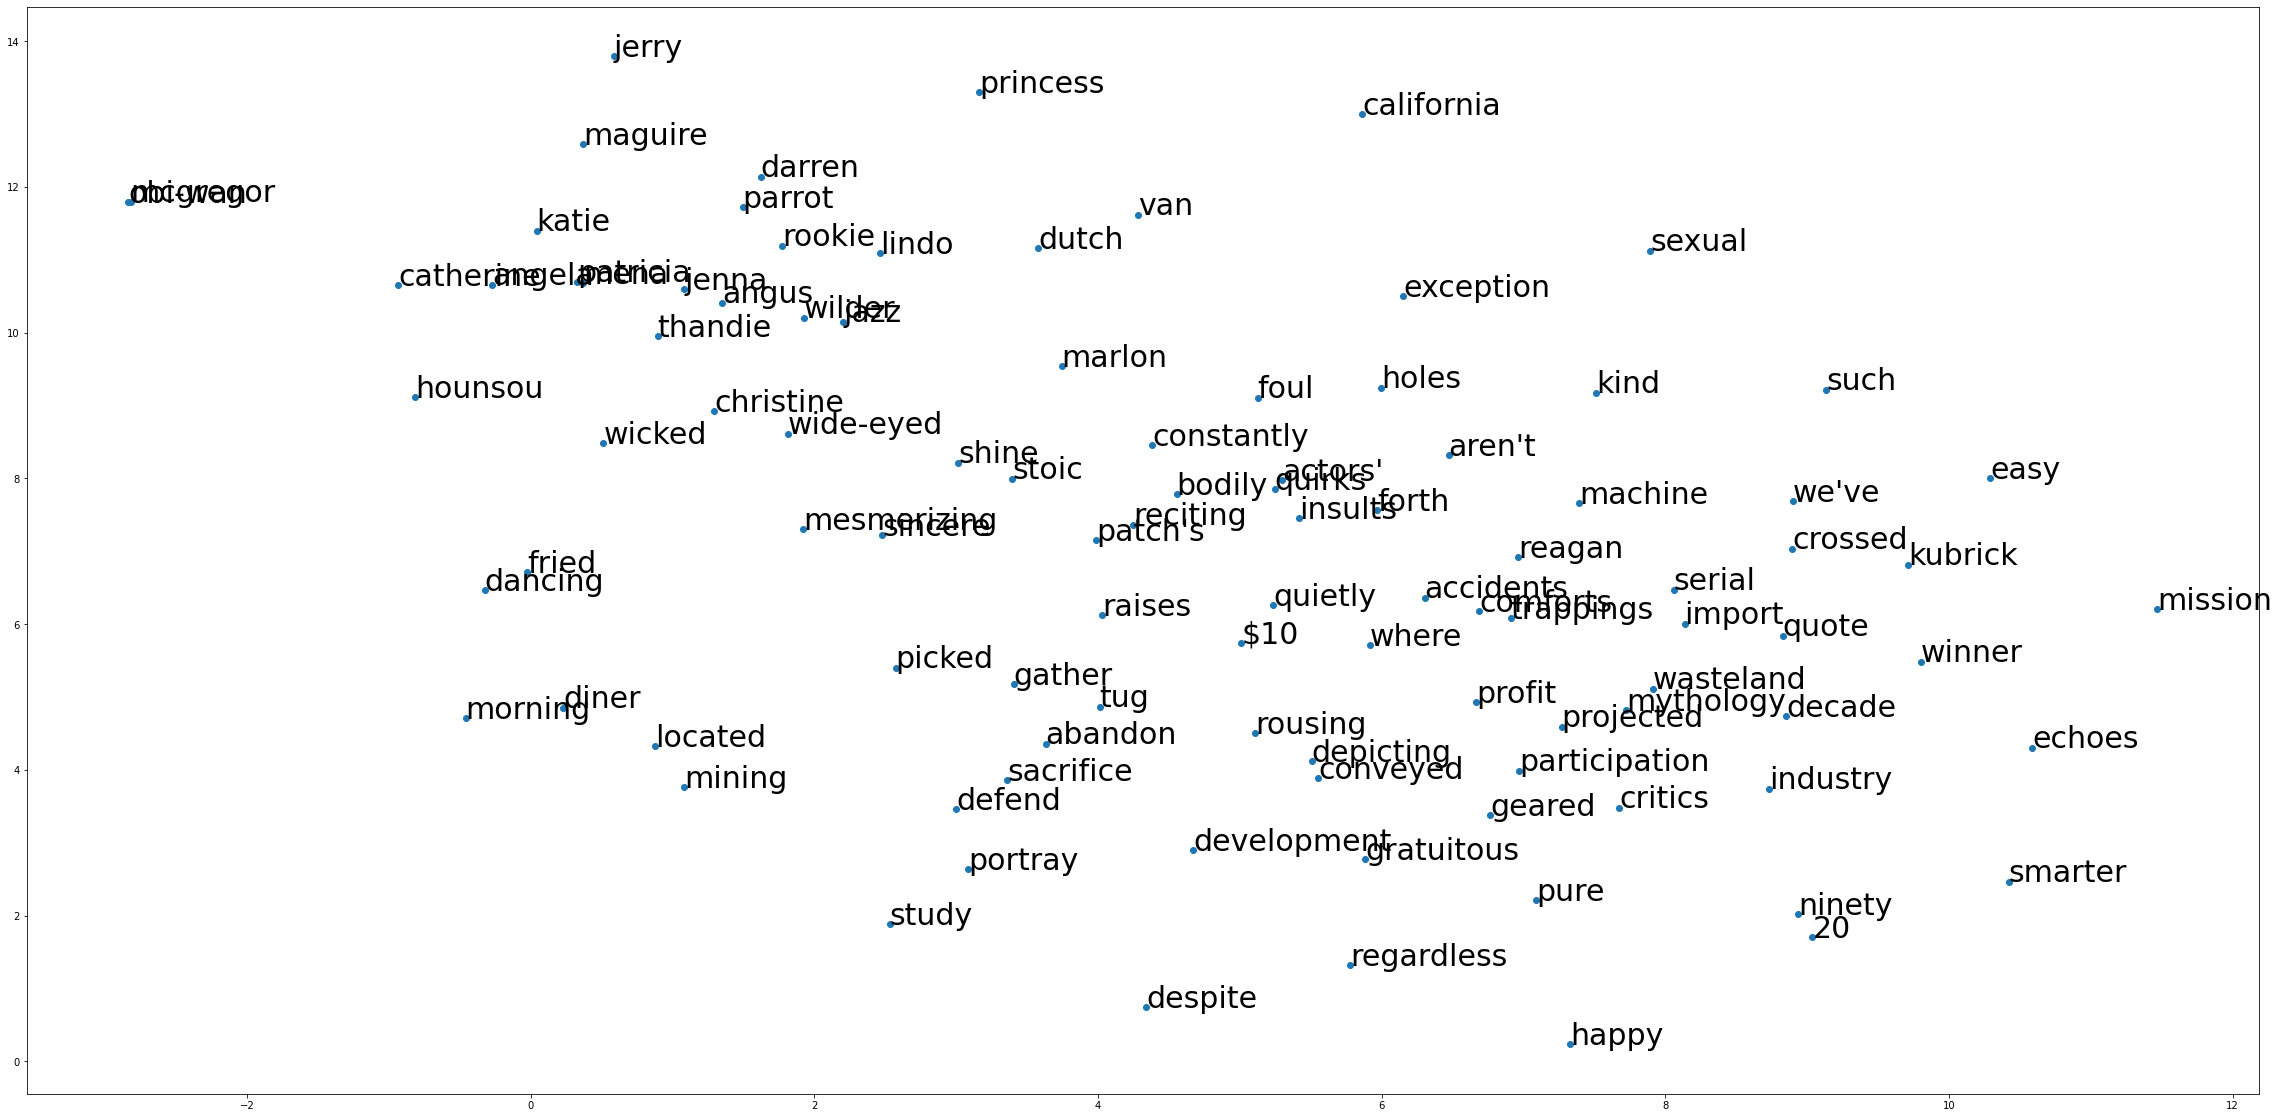

In [ ]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

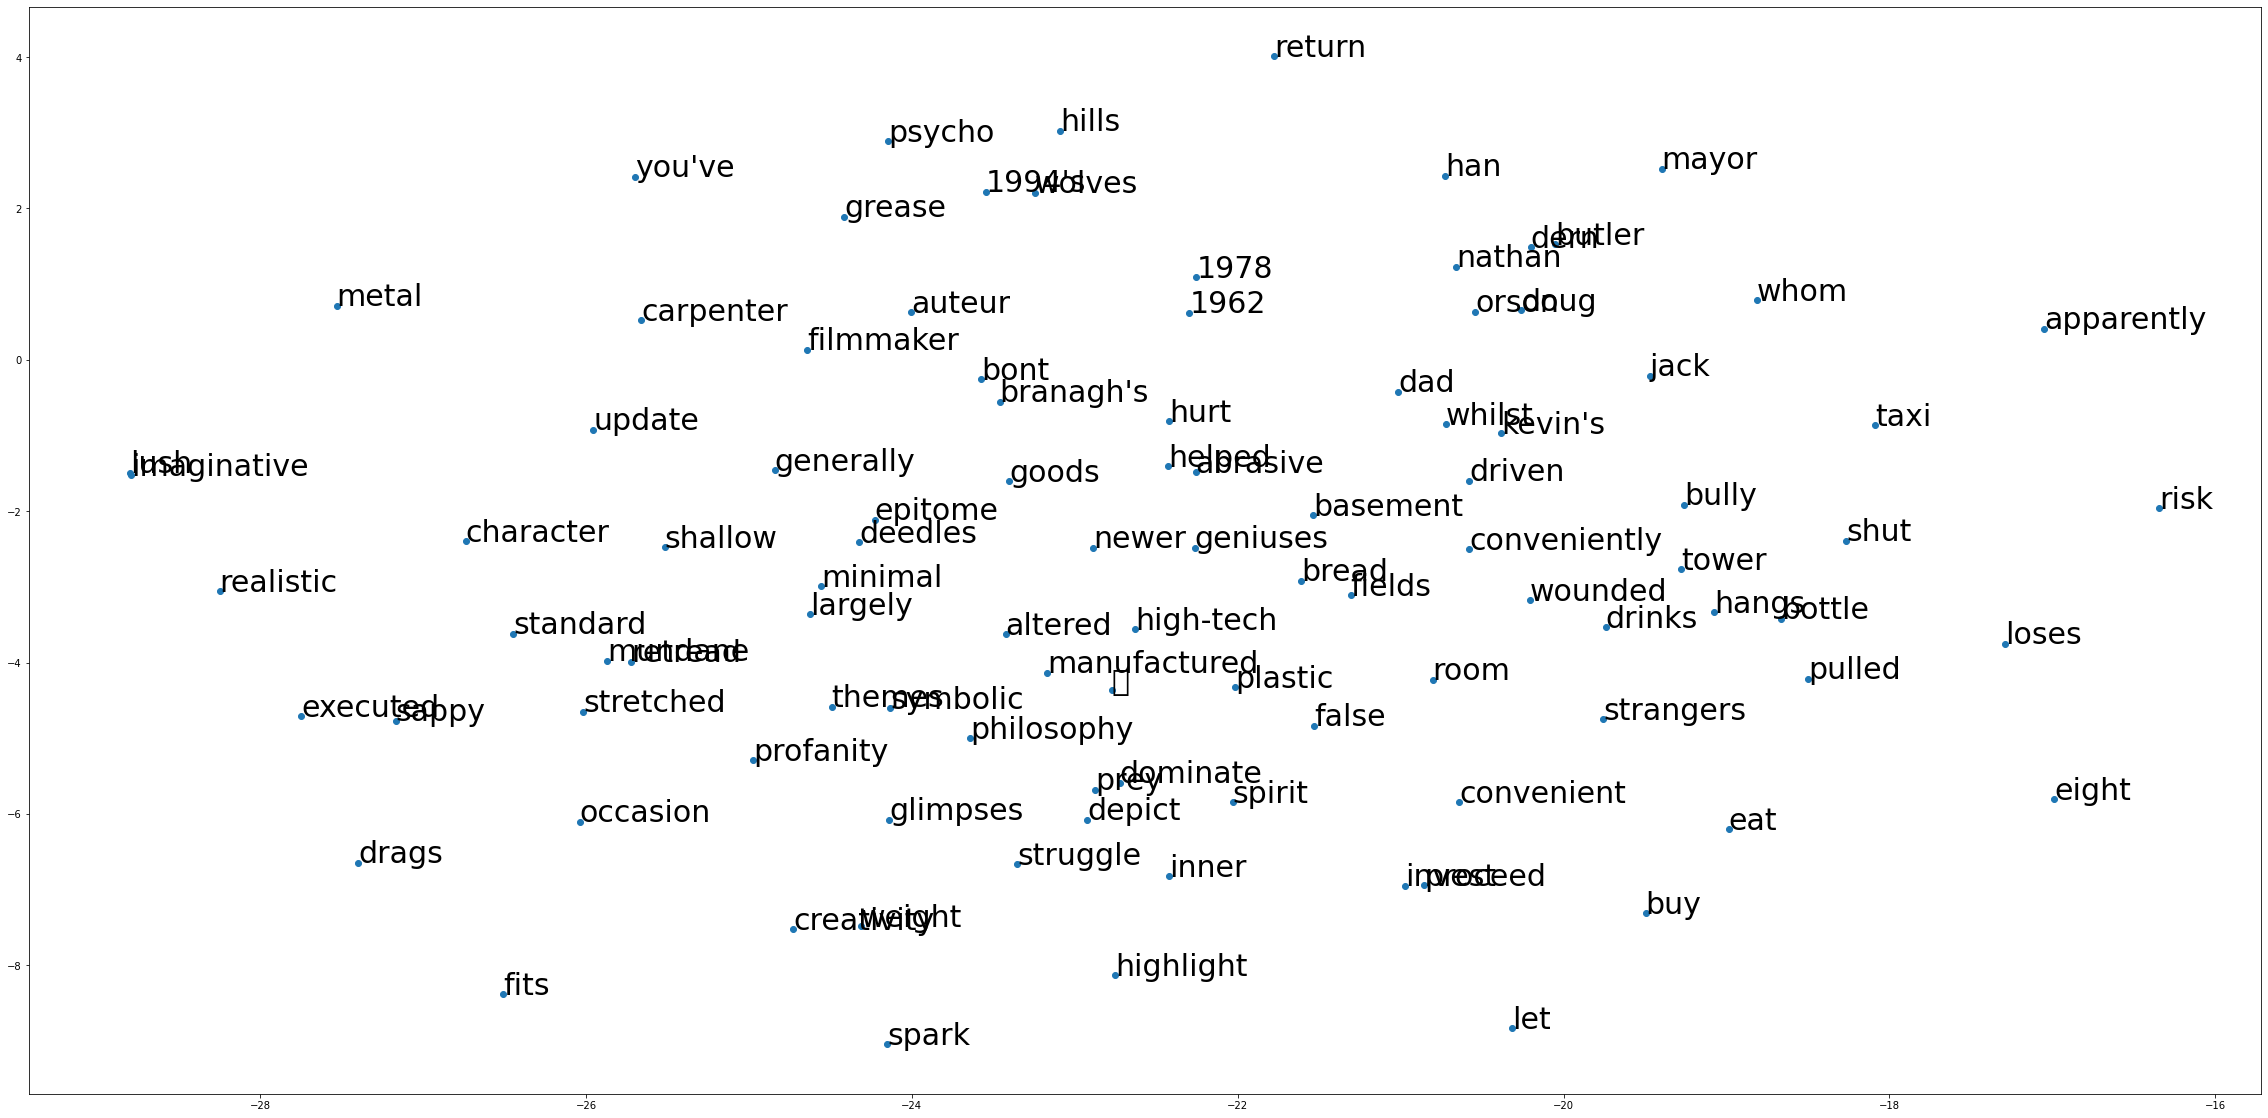

In [ ]:
# CBOW 시각화(TSNE)
vocab = list(CBOW.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화